In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import train_test_split
import random
from sklearn.metrics import log_loss
from math import exp
import xgboost as xgb
from XGBoostPackage import xgbClass
from CrossValidation import CVScore
# from difflib import SequenceMatcher
import editdistance

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
random.seed(321)
np.random.seed(321)

X_train = pd.read_json("../input/train.json")
X_test = pd.read_json("../input/test.json")

In [3]:
interest_level_map = {'low': 0, 'medium': 1, 'high': 2}
X_train['interest_level'] = X_train['interest_level'].apply(lambda x: interest_level_map[x])
X_test['interest_level'] = -1
X_train['features'] = X_train["features"].apply(lambda x: " ".join(["_".join(i.strip().lower().split(" ")) for i in x]))
X_test['features'] = X_test["features"].apply(lambda x: " ".join(["_".join(i.strip().lower().split(" ")) for i in x]))

In [4]:
def clean(x):
#     x = s.replace("-", "")
#     x = x.replace(" ", "")
#     x = x.replace("twenty_four_hour", "24")
#     x = x.replace("24/7", "24")
#     x = x.replace("24hr", "24")
#     x = x.replace("24-hour", "24")
#     x = x.replace("24hour", "24")
#     x = x.replace("24 hour", "24")
    for i in ['24_hour_concierge/doorman','24/7_doorman_concierge',
              '24-hour_doorman',
              '24/7_concierge',
              '24/7_doorman',
              '24hr_doorman']+['24_hour_doorman']\
    +['twenty-four_hour_concierge_and_doorman'\
             ,'time_doorman','full-time_doorman','ft_doorman']:
        x = x.replace(i, '24hr_doorman')
    #x = x.replace("common", "cm")
    for i in ['cable/satellite_tv', 'cable_ready']:
        x = x.replace(i, 'cable')
    for i in ["children's_playroom",
#               'children\xe2\x80\x99s_playroom',
              'childrens_playroom']:
        x = x.replace(i, "children's_playroom")
    #x = x.replace("concierge", "doorman")
    #x = x.replace("bicycle", "bike")
    for i in ['bicycle_room', 'bike_room', 'bike_storage']:
        x = x.replace(i, 'bike_room')
    for i in ['billiards_room',
              'billiards_table_and_wet_bar']:
        x = x.replace(i, 'billiards')
    for i in ['concierge_service', 'concierge', 'doorman_service', 'doorman'
             ]:
        x = x.replace(i, 'doorman')
    #x = x.replace("private", "pv")
    #x = x.replace("deco", "dc")
    #x = x.replace("decorative", "dc")
    x = x.replace('deco_brick_walls', 'deco_brick_wall')
    x = x.replace('decorative_fireplace','deco_fireplace')
    x = x.replace('dish_washer', 'dishwasher')
    x = x.replace('_exposed_brick_','exposed_brick')
    #x = x.replace("onsite", "os")
    #x = x.replace("outdoor", "od")
    for i in ['fitness_center', 'fitness_facility', 'fitness_room']\
    +['gym/fitness','gym_in_building']:
        x = x.replace(i, 'gym')
    x = x.replace('fireplaces','fireplace')
    for i in ['eat-in_kitchen'\
             ,'in_kitchen_', 'in_kitchen','eat_in_kitchen','s_kitchen_','_kitchen_'\
             ,'eat_kitchen'\
             ,'_skitchen']:
        x = x.replace(i,'kitchen')
#     x = x.replace("ft","full-time")
    for i in ['granite_countertops',
              'granite_counter_tops',
              'granite_counters',
              'granite_counter',
              'granite_kitchen']:
        x = x.replace(i, 'granite')
    for i in ['hardwood_floors','hardwood_floor']:
        x = x.replace(i, 'hardwood')
    x = x.replace('high_ceilings','high_ceiling')
    for i in ['high-speed_internet',
#               'high_floor',
#              'high_speed_internet',
              'high_speed_internet_available']:
#               'highrise']:
        x = x.replace(i, 'high_speed_internet')
    x = x.replace('large_living-room', 'large_living_room')
    x = x.replace('laundry_on_every_floor','laundry_on_floor')
    x = x.replace('marble_bathroom','marble_bath')
    x = x.replace('media_screening_room','media_room')
    x = x.replace('multi-level', 'multi_level')
    for i in ['parking_space','on-site_parking',
              'on-site_parking_available',
              'parking_available',
              'on-site_parking_lot']\
    :
        x = x.replace(i, 'parking')
    for i in ['pets:_cats/small_dogs',
              'pets_allowed',
              #'cats_allowed','dogs_allowed',
              'pets_on_approval']\
    +['all_pets_ok','_pets_ok_','pet_friendly']\
    :
        x = x.replace(i, 'pets')
    for i in ['pre_war']+['pre-war', 'prewar', 'pre']:
        x = x.replace(i, 'pre')
    for i in ['post-war', 'post_war', 'postwar', 'post']:
        x = x.replace(i, 'post')
    x = x.replace('publicoutdoor','outdoor')
    for i in ['common_roof_deck','common_roof',
              'roof-deck',
              'roof_access',
              'roof_decks',
              'roof_deck',
              #'roof_deck_with_grills',
              'rooftop_deck',
              'roofdeck',
              'rooftop_terrace',
              'rooftop']:
        x = x.replace(i,'roof')
    x = x.replace('shares_ok','share_ok')
    for i in ["ss appliances", 
              'stainless_steel_appliances',
              'stainless_steel_kitchen',
             'stainless_steel']:
        x = x.replace(i, "stainless")
    for i in ['storage_available',
              'storage_facilities_available',
              'storage_room',
              'storage_space']:
        x = x.replace(i, 'storage')
    for i in ['super_on-site', 'on-site_super']+['live-in_super',
              'live-in_superintendent',
              'live/work',
              'live_in_super','site_super','superintendent']:
        x = x.replace(i, 'super')
    x.replace('swimming_pool', 'pool')
    for i in ['valet_laundry',
#               'valet_parking',
              'valet_services',
              'valet_services_(housekeeping/dry_cleaning_available)',
              'valet_services_including_dry_cleaning','laundry_&_housekeeping',
              'valet_service']:
        x = x.replace(i, 'valet')
    for i in ['washer/dryer_in-unit','washer_in_unit', 'laundry_in_unit','dryer_in_unit']:
        x = x.replace(i,'washer_in_unit')    
    for i in [#'walk-up',
#              'walk_in_closet',
              'walk_in_closet(s)',
              'closet_space',
              'walk-in_closet',
             ]:
        x = x.replace(i, 'closet')
    for i in ['dry_cleaning_service',
              'washer/dryer_hookup',
              'washer/dryer_in_bldg',
              'washer/dryer_in_building',              
              'washer_&_dryer','laundry_in_building','laundry_room',
              'site_laundry','_washer','dryer']:
        x = x.replace(i, 'laundry')
    x = x.replace('wheelchair_ramp', 'wheelchair_access')
    for i in ['wi-fi_access',
              'wifi_access',
              'wifi_in_resident_lounge']+['free_wifi', 'free_wifi_in_club_lounge']:
        x = x.replace(i, 'wifi')
    return x

In [5]:
print(X_train.shape)
X_train['features']=X_train['features'].apply(clean)
X_test['features']=X_test['features'].apply(clean)
X_train.head(1)

(49352, 15)


,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,,1,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue


In [6]:
X_train['features'].head(20)

10                                                         
10000        doorman elevator gym cats_allowed dogs_allowed
100004        laundry dishwasher hardwood pets_case_by_case
100007                                      hardwood no_fee
100013                                                  pre
100014                                                     
100016    pre elevator dogs_allowed cats_allowed lowrise...
100020    doorman elevator pre terrace washer_in_unit di...
100026           cats_allowed dogs_allowed elevator laundry
100027                                  dishwasher hardwood
100030                                                     
10004     pre dishwasher highrise roof kitchen simplex h...
100044                      doorman elevator laundry no_fee
100048    swimming_pool doorman gym no_fee dogs_allowed ...
10005      elevator multi_level laundry dishwasher hardwood
100051                  doorman elevator gym laundry no_fee
100052                                  

In [7]:
#add features
feature_transform = CountVectorizer(stop_words='english', max_features=150)
# X_train['features'] = X_train["features"].apply(lambda x: " ".join(["_".join(i.lower().split(" ")) for i in x]))
# X_test['features'] = X_test["features"].apply(lambda x: " ".join(["_".join(i.lower().split(" ")) for i in x]))
feature_transform.fit(list(X_train['features']) + list(X_test['features']))

train_size = len(X_train)
low_count = len(X_train[X_train['interest_level'] == 0])
medium_count = len(X_train[X_train['interest_level'] == 1])
high_count = len(X_train[X_train['interest_level'] == 2])

In [8]:
def find_objects_with_only_one_record(feature_name):
    temp = pd.concat([X_train[feature_name].reset_index(), 
                      X_test[feature_name].reset_index()])
    temp = temp.groupby(feature_name, as_index = False).count()
    return temp[temp['index'] == 1]

managers_with_one_lot = find_objects_with_only_one_record('manager_id')
buildings_with_one_lot = find_objects_with_only_one_record('building_id')
addresses_with_one_lot = find_objects_with_only_one_record('display_address')


In [9]:
lambda_val = None
k=5.0
f=1.0
r_k=0.01 
g = 1.0
def categorical_average(variable, y, pred_0, feature_name):
    def calculate_average(sub1, sub2):
        s = pd.DataFrame(data = {
                                 variable: sub1.groupby(variable, as_index = False).count()[variable],                              
                                 'sumy': sub1.groupby(variable, as_index = False).sum()['y'],
                                 'avgY': sub1.groupby(variable, as_index = False).mean()['y'],
                                 'cnt': sub1.groupby(variable, as_index = False).count()['y']
                                 })
                                 
        tmp = sub2.merge(s.reset_index(), how='left', left_on=variable, right_on=variable) 
        del tmp['index']                       
        tmp.loc[pd.isnull(tmp['cnt']), 'cnt'] = 0.0
        tmp.loc[pd.isnull(tmp['cnt']), 'sumy'] = 0.0

        def compute_beta(row):
            cnt = row['cnt'] if row['cnt'] < 200 else float('inf')
            return 1.0 / (g + exp((cnt - k) / f))
            
        if lambda_val is not None:
            tmp['beta'] = lambda_val
        else:
            tmp['beta'] = tmp.apply(compute_beta, axis = 1)
            
        tmp['adj_avg'] = tmp.apply(lambda row: (1.0 - row['beta']) * row['avgY'] + row['beta'] * row['pred_0'],
                                   axis = 1)
                                   
        tmp.loc[pd.isnull(tmp['avgY']), 'avgY'] = tmp.loc[pd.isnull(tmp['avgY']), 'pred_0']
        tmp.loc[pd.isnull(tmp['adj_avg']), 'adj_avg'] = tmp.loc[pd.isnull(tmp['adj_avg']), 'pred_0']
        tmp['random'] = np.random.uniform(size = len(tmp))
        tmp['adj_avg'] = tmp.apply(lambda row: row['adj_avg'] *(1 + (row['random'] - 0.5) * r_k),
                                   axis = 1)
    
        return tmp['adj_avg'].ravel()
     
    #cv for training set 
    k_fold = StratifiedKFold(5)
    X_train[feature_name] = -999 
    for (train_index, cv_index) in k_fold.split(np.zeros(len(X_train)),
                                                X_train['interest_level'].ravel()):
        sub = pd.DataFrame(data = {variable: X_train[variable],
                                   'y': X_train[y],
                                   'pred_0': X_train[pred_0]})
            
        sub1 = sub.iloc[train_index]        
        sub2 = sub.iloc[cv_index]
        
        X_train.loc[cv_index, feature_name] = calculate_average(sub1, sub2)
    
    #for test set
    sub1 = pd.DataFrame(data = {variable: X_train[variable],
                                'y': X_train[y],
                                'pred_0': X_train[pred_0]})
    sub2 = pd.DataFrame(data = {variable: X_test[variable],
                                'y': X_test[y],
                                'pred_0': X_test[pred_0]})
    X_test.loc[:, feature_name] = calculate_average(sub1, sub2)                               



In [10]:
def transform_data(X):
    #add features    
    feat_sparse = feature_transform.transform(X["features"])
    vocabulary = feature_transform.vocabulary_
    del X['features']
    X1 = pd.DataFrame([ pd.Series(feat_sparse[i].toarray().ravel()) for i in np.arange(feat_sparse.shape[0]) ])
    X1.columns = list(sorted(vocabulary.keys()))
    X = pd.concat([X.reset_index(), X1.reset_index()], axis = 1)
    del X['index']
    
    X["num_photos"] = X["photos"].apply(len)
    X['created'] = pd.to_datetime(X["created"])
    X["num_description_words"] = X["description"].apply(lambda x: len(x.split(" ")))
    X['price_per_bed'] = X['price'] / X['bedrooms']    
    X['price_per_bath'] = X['price'] / X['bathrooms']
    X['price_per_room'] = X['price'] / (X['bathrooms'] + X['bedrooms'] )
    
    X['low'] = 0
    X.loc[X['interest_level'] == 0, 'low'] = 1
    X['medium'] = 0
    X.loc[X['interest_level'] == 1, 'medium'] = 1
    X['high'] = 0
    X.loc[X['interest_level'] == 2, 'high'] = 1
    
    X['display_address'] = X['display_address'].apply(lambda x: x.lower().strip())
    X['street_address'] = X['street_address'].apply(lambda x: x.lower().strip())
#     def similar(a, b):
#         return SequenceMatcher(None, a, b).ratio()
#     X['display_street_dist']=X.apply(lambda row: similar(row['display_address'], row['street_address']), axis=1)
    X['display_street_dist']=X.apply(lambda row: editdistance.eval\
                                     (row['display_address'], row['street_address']), axis=1)
    
    X['pred0_low'] = low_count * 1.0 / train_size
    X['pred0_medium'] = medium_count * 1.0 / train_size
    X['pred0_high'] = high_count * 1.0 / train_size
    
    X.loc[X['manager_id'].isin(managers_with_one_lot['manager_id'].ravel()), 
          'manager_id'] = "-1"
    X.loc[X['building_id'].isin(buildings_with_one_lot['building_id'].ravel()), 
          'building_id'] = "-1"
    X.loc[X['display_address'].isin(addresses_with_one_lot['display_address'].ravel()), 
          'display_address'] = "-1"
          
    return X

def normalize_high_cordiality_data():
    high_cardinality = ["building_id", "manager_id"]
    for c in high_cardinality:
        categorical_average(c, "medium", "pred0_medium", c + "_mean_medium")
        categorical_average(c, "high", "pred0_high", c + "_mean_high")

def transform_categorical_data():
    categorical = ['building_id', 'manager_id', 
                   'display_address', 'street_address']
                   
    for f in categorical:
        encoder = LabelEncoder()
        encoder.fit(list(X_train[f]) + list(X_test[f])) 
        X_train[f] = encoder.transform(X_train[f].ravel())
        X_test[f] = encoder.transform(X_test[f].ravel())
                  

def remove_columns(X):
    columns = ["photos", "pred0_high", "pred0_low", "pred0_medium",
               "description", "low", "medium", "high",
               "interest_level", "created"]
    for c in columns:
        del X[c]

In [11]:
print("Starting transformations")        
X_train = transform_data(X_train)    
X_test = transform_data(X_test) 
y_train = X_train['interest_level'].ravel()

print("Normalizing high cordiality data...")
normalize_high_cordiality_data()
transform_categorical_data()




Starting transformations
Normalizing high cordiality data...


In [32]:
(X_train['interest_level'])[(X_train['dogs_allowed']==1)&(X_train['cats_allowed']==1)]

1        0
6        0
8        1
13       0
18       0
19       0
22       0
23       0
24       1
30       1
31       1
32       0
34       0
35       0
36       0
37       2
39       1
41       0
45       1
47       0
49       0
58       1
62       0
63       0
65       0
67       0
70       0
72       0
73       0
75       0
        ..
49289    1
49291    0
49292    0
49293    0
49294    0
49297    0
49299    0
49300    0
49303    0
49306    0
49309    0
49314    0
49317    2
49318    0
49320    1
49322    0
49323    0
49324    1
49326    0
49328    0
49329    0
49332    0
49333    0
49334    0
49338    0
49341    0
49342    2
49348    0
49349    0
49350    0
Name: interest_level, dtype: int64

In [12]:
remove_columns(X_train)
remove_columns(X_test)

In [18]:
print(X_train.shape)
X_train.head(2)

(49352, 170)


,bathrooms,bedrooms,building_id,display_address,latitude,listing_id,longitude,manager_id,price,street_address,...,num_photos,num_description_words,price_per_bed,price_per_bath,price_per_room,display_street_dist,building_id_mean_medium,building_id_mean_high,manager_id_mean_medium,manager_id_mean_high
0,1.5,3,2103,10443,40.7145,7211212,-73.9425,1203,3000,21630,...,5,95,1000.0,2000.0,666.666667,4,0.217575,7.436940e-02,0.283585,9.190504e-29
1,1.0,2,5077,7525,40.7947,7150865,-73.9667,1518,5465,21801,...,11,9,2732.5,5465.0,1821.666667,4,0.110642,1.761506e-07,0.012447,2.088626e-34


In [13]:
featuresInUse = [f for f in X_train.columns if f not in ['manager_id', 'building_id', "display_address"]\
                  +['war','eat','on','building']                                       
                ]
                                                        #,'no_pets','_pets_ok_','bedrooms', 'dryer_in_unit',
                                                        #'health_club','common', 
#                  +list(imp.sort_values("train").head(10).index)]
#featuresInUse = [f for f in X_train.columns if f not in []]
len(featuresInUse)

166

In [14]:
#cross validation

X_fit, X_val, y_fit, y_val=train_test_split(X_train[featuresInUse][:], y_train[:], test_size=0.33, random_state=42)

In [15]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.1
param['max_depth'] = 4
param['silent'] = 1
param['num_class'] = 3
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 1
param['subsample'] = 0.7
param['colsample_bytree'] = 0.7
param['seed'] = 321
param['nthread'] = 8
num_rounds = 1000


In [18]:
xgfit = xgb.DMatrix(X_fit, label=y_fit)
clfCV = xgb.train(param, xgfit, num_rounds)#, early_stopping_rounds=20)

xgval = xgb.DMatrix(X_val)
y_val_pred = clfCV.predict(xgval)
log_loss(y_val, y_val_pred)
#0.535112: 2000, f not in ['manager_id', 'building_id', "display_address"\,'common_roof_deck']]

0.54070154892138522

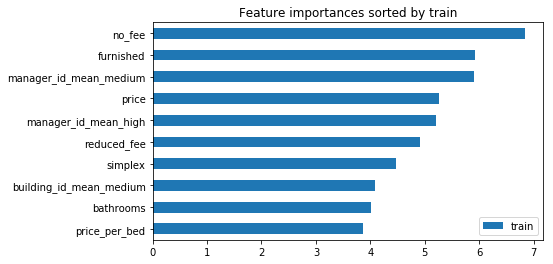

In [19]:
imp=pd.DataFrame()#(index=features_to_use)
imp['train'] = pd.Series(clfCV.get_score(importance_type='gain'))#, index=features_to_use)
imp = imp.fillna(0)
ax=imp.sort_values('train').tail(10).plot.barh(title='Feature importances sorted by train', figsize=(7,4))

In [20]:
print(len(imp))
imp.sort_values('train',ascending=False).head(45)

116


,train
no_fee,6.832627
furnished,5.916131
manager_id_mean_medium,5.908225
price,5.268768
manager_id_mean_high,5.205327
reduced_fee,4.920318
simplex,4.465752
building_id_mean_medium,4.092751
bathrooms,4.012359
price_per_bed,3.859395


In [21]:
imp.sort_values('train',ascending=False).tail(50)

,train
pool,1.911017
fireplace,1.902133
loft,1.895044
kitchen,1.878930
pre,1.854891
elevator,1.852519
super,1.846219
subway,1.748690
private_balcony,1.686147
valet,1.654724


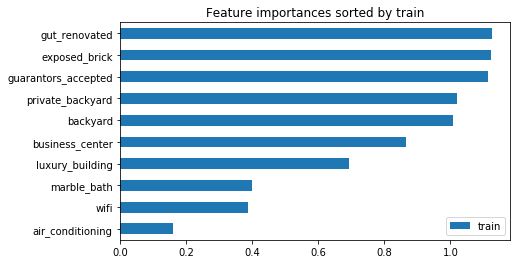

In [22]:
ax=imp.sort_values('train').head(10).plot.barh(title='Feature importances sorted by train', figsize=(7,4))

In [28]:
X_train[featuresInUse][:1]

,bathrooms,bedrooms,latitude,listing_id,longitude,price,street_address,24hr_doorman,_balconies,_chef,...,num_photos,num_description_words,price_per_bed,price_per_bath,price_per_room,display_street_dist,building_id_mean_medium,building_id_mean_high,manager_id_mean_medium,manager_id_mean_high
0,1.5,3,40.7145,7211212,-73.9425,3000,21630,0,0,0,...,5,95,1000.0,2000.0,666.666667,4,0.217575,0.074369,0.283585,9.190504e-29


In [24]:
param_grid = {'eta':[.02, .05], 'num_round':[1500,2000,2500], 'subsample':[.7], 'colsample_bytree':[.65,.85], \
              'max_depth':[4,5], 'seed':[2017]}
for eta in param_grid['eta']:
    for subsample in param_grid['subsample']:
        for colsample_bytree in param_grid['colsample_bytree']:
            for max_depth in param_grid['max_depth']:
                for seed in param_grid['seed']:
                    for num_rounds in param_grid['num_round']:
                        model=xgbClass(colsample_bytree=colsample_bytree, eta=eta, eva_metric='mlogloss', \
                                       subsample=subsample, max_depth=max_depth, seed=seed,\
                                       objective='multi:softprob', num_class=3,num_rounds=num_rounds)
                        score=CVScore(model=model, my_score=log_loss, X_train=(X_train[featuresInUse])[:100],\
                                  y_train=y_train[:100])
                        del model
                        print('eta={}, subsample={}, colsample_bytree={}, max_depth={}, seed={}, score={}, num_rounds={}'.\
                          format(eta, subsample, colsample_bytree, max_depth, seed, score, num_rounds))

eta=0.02, subsample=0.7, colsample_bytree=0.65, max_depth=4, seed=2017, score=1.05677167543, num_rounds=1500
eta=0.02, subsample=0.7, colsample_bytree=0.65, max_depth=4, seed=2017, score=1.08321649204, num_rounds=2000
eta=0.02, subsample=0.7, colsample_bytree=0.65, max_depth=4, seed=2017, score=1.10272785452, num_rounds=2500
eta=0.02, subsample=0.7, colsample_bytree=0.65, max_depth=5, seed=2017, score=1.0581438732, num_rounds=1500
eta=0.02, subsample=0.7, colsample_bytree=0.65, max_depth=5, seed=2017, score=1.08491223451, num_rounds=2000
eta=0.02, subsample=0.7, colsample_bytree=0.65, max_depth=5, seed=2017, score=1.10364146405, num_rounds=2500
eta=0.02, subsample=0.7, colsample_bytree=0.85, max_depth=4, seed=2017, score=1.07095665254, num_rounds=1500
eta=0.02, subsample=0.7, colsample_bytree=0.85, max_depth=4, seed=2017, score=1.09563050426, num_rounds=2000
eta=0.02, subsample=0.7, colsample_bytree=0.85, max_depth=4, seed=2017, score=1.11406079073, num_rounds=2500
eta=0.02, subsample=

In [14]:
print("Start fitting...")

# param = {}
# param['objective'] = 'multi:softprob'
# param['eta'] = 0.02
# param['max_depth'] = 4
# param['silent'] = 1
# param['num_class'] = 3
# param['eval_metric'] = "mlogloss"
# param['min_child_weight'] = 1
# param['subsample'] = 0.7
# param['colsample_bytree'] = 0.7
# param['seed'] = 321
# param['nthread'] = 8
# num_rounds = 2000

xgtrain = xgb.DMatrix(X_train[featuresInUse], label=y_train)
clf = xgb.train(param, xgtrain, num_rounds)

print("Fitted")

def prepare_submission(model):
    xgtest = xgb.DMatrix(X_test[featuresInUse])
    preds = model.predict(xgtest)    
    sub = pd.DataFrame(data = {'listing_id': X_test['listing_id'].ravel()})
    sub['low'] = preds[:, 0]
    sub['medium'] = preds[:, 1]
    sub['high'] = preds[:, 2]
    sub.to_csv("It_is_lit2.csv", index = False, header = True)

prepare_submission(clf)

Start fitting...
Fitted
